In [47]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import curve_fit, minimize
from scipy.integrate import odeint
import warnings
warnings.filterwarnings("ignore")

Import of the experimental data

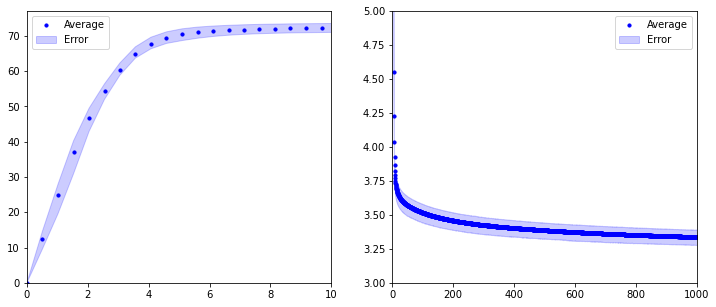

In [48]:
# Build plots of Association and Dissociation of BP proteins
# Red lines represent averaged values, when filled blue area represents experimental errors

datd100d = np.loadtxt('diss_PBS_100%.txt')
td100 = datd100d[:, 0]
yd100 = datd100d[:, 1:]
td100 = (td100-min(td100))
yd100ave= np.mean(yd100, axis=1)
yd100ave=np.delete(yd100ave, 0)
td100 = np.delete(td100, -1)

yd100min = np.min(yd100, axis=1)
yd100min = np.delete(yd100min, 0)

yd100max = np.max(yd100, axis=1)
yd100max = np.delete(yd100max, 0)


data100 = np.loadtxt('assoc_PBS_100%.txt')
Ta100 = data100[:, 0]
ya100 = data100[:, 1:]
ta100 = (Ta100-min(Ta100))

ya100ave = np.mean(ya100, axis=1)
ya100ave = np.delete(ya100ave, [0,1,2])
ya100ave = np.insert(ya100ave, 0, 0)

ya100min = np.min(ya100, axis=1)
ya100min = np.delete(ya100min, [0,1,2])
ya100min = np.insert(ya100min, 0, 0)

ya100max = np.max(ya100, axis=1)
ya100max = np.delete(ya100max, [0,1,2])
ya100max = np.insert(ya100max, 0, 0)

ta100 = np.delete(ta100, [-1,-2])

f, (ax1,ax2) = plt.subplots(1,2, sharey=False)

ax1.scatter(ta100, ya100ave, s=10, color='blue', label="Average")
ax1.fill_between(ta100, ya100min, ya100max, color='blue', label='Error', alpha=0.2)
ax1.legend(loc='best')

ax2.scatter(td100, yd100ave, s=10, color='blue', label="Average")
ax2.fill_between(td100, yd100min, yd100max, color='blue', label='Error', alpha=0.2)
ax2.legend(loc='best')

ax1.set_ylim(0,77)
ax1.set_xlim(0,10)

ax2.set_ylim(3,5)
ax2.set_xlim(0,1000)


f.set_figheight(5)
f.set_figwidth(12)
plt.show()



As it is a discrete approach here we define the class, which devide experimental curves into parts

In [49]:

class Partition:
    def __init__(self):
        pass  

    # methods extract fast, medium or slow parts of measured binding correspondingly, time starts from zero;
    # INPUTS:
    # time_point1: int or float - time point of the border between fast and medium binding
    # time_point2: int or float - time point of the border between medium and slow binding
    # x: np.array               - experimental time points array, experimental
    # y: np.array               - experimental values of SPR signal
    # ground: bool              - if True, the curve shifts down, i.e. minimum value of signal is set at zero
    # OUTPUT:
    # np.array([x,y])  
    
    def fast_part(self,time_point1, x,y, ground=False):
        self.time_point1 = time_point1
        self.x = x
        self.y = y
        self.ground = ground
    
        n=np.searchsorted(x,time_point1)

        if abs(time_point1-x[n-1])<=abs(time_point1-x[n]):
            n=n-1

        y_new=np.delete(y,np.arange(n+1, len(y)))
        
        if ground==True:
            y_new=y_new-np.min(y_new)
            
        x_new = np.delete(x,np.arange(n+1,len(y)))

        return np.array([x_new,y_new])

    def slow_part(self,time_point2, x,y, ground=False):
        
        self.time_point2 = time_point2
        self.x = x
        self.y = y
        self.ground = ground
            
        n=np.searchsorted(x,time_point2)

        if abs(time_point2-x[n-1])<=abs(time_point2-x[n]):
            n=n-1

        y_new=np.delete(y,np.arange(0,n))
        
        if ground==True:
            y_new=y_new-np.min(y_new)
            
        x_new=np.delete(x,np.arange(0,n))
        x_new = x_new - np.min(x_new)

        return np.array([x_new, y_new])

    def mid_part(self,time_point1,time_point2,x,y, ground=False):
        
        self.time_point1 = time_point1
        self.time_point2 = time_point2
        self.x = x
        self.y = y
        self.ground = ground

        n1=np.searchsorted(x,time_point1)
        n2=np.searchsorted(x,time_point2)
        del_arr1=np.arange(0,n1)
        del_arr2=np.arange(n2,len(y))
        y_new=np.delete(y, np.concatenate((del_arr1,del_arr2)))
        if ground==True:
            y_new=y_new-np.min(y_new)

        x_new=np.delete(x,np.concatenate((del_arr1,del_arr2)))
        x_new = x_new - np.min(x_new)
        return np.array([x_new,y_new])
      

Partition of the curve

In [51]:
cut_off = Partition()                                # Call of the Partition class
xmd, ymd = cut_off.mid_part(3.5,600,td100,yd100ave)  # getting curve of medium binding in Dissociation phase
xsd, ysd = cut_off.slow_part(600,td100,yd100ave)     # getting curve of slow binding in Dissociation phase
xfd, yfd = cut_off.fast_part(3.5,td100,yd100ave)     # getting curve of fast binding in Dissociation phase

xma, yma = cut_off.mid_part(3.5,80,ta100,ya100ave)   # getting curve of medium binding in Association phase
xsa, ysa = cut_off.slow_part(80,ta100,ya100ave)      # getting curve of slow binding in Association phase
xfa, yfa = cut_off.fast_part(3.5,ta100,ya100ave)     # getting curve of fast binding in Association phase

Define methods, which represent approximating equations for Adsorption and Desorption correspondingly

In [52]:
# Arguments:
# ta,td: np.array     - array of arguments of the function (experimental time points)
# R_max: int or float - value of equlibrium or max value of the signal in Association or Dissociation, respectively
# kc1: float          - value of product of coefficient of association rate and concentration (k_a*C), as impossible to split it
# kd1: float          - value of the coefficient of dissociation rate
# Return values of functions

def assoc(ta, R_max, kc1, kd1):
    f = R_max*(1-np.exp(-(kc1+kd1)*ta)) # integrated Lengmuir adsorption equation, which describes adsorption of proteins on the surface
    return f
def diss(td, R_max, kd1):
    f = R_max*np.exp(-kd1*td)           # integrated Lengmuir adsorption equation, which describes desorption of proteins on the surface
    return f

Function which fits approximating functions to both association and dissociation and calculates loss function value.
The idea is to apply it to already partitied experimental curves. Fitting of partitied curves is conjugated, i.e. curve for fast association and fast dissociation are taken together to be fitted.

In [53]:
def opti(pars):
    kc1, kd1 = pars                         # Parameters to be optimized
    
    ya_foo=assoc(xa, R_eq, *pars)           # Values of the approximation for Association
    loss1= np.mean((ya - ya_foo)**2)        # Vulues of loss function for Association
    yd_foo=diss(xd, np.max(yd), pars[-1] )  # Values of the approximation for Dissociation
    loss2 = np.mean((yd - yd_foo)**2)       # Values of loss function for Dissociation
    loss = np.sum(loss1)+np.sum(loss2)      # Metrics of losses  to be minimized
    return loss

OPTIMIZATION

In [55]:
# Set parameters for partition

end_of_fast_assoc = 7
start_of_slow_assoc = 120
end_of_fast_diss = 7
start_of_slow_diss = 600

# Set parameters for optimization
R_eq_fast = 75
R_eq_medium = 3
R_eq_slow = 170

# Partition itself
cut_it = Partition()
xma, yma = cut_it.mid_part(end_of_fast_assoc, start_of_slow_assoc, ta100, ya100ave,ground=True)
xsa, ysa = cut_it.slow_part(start_of_slow_assoc, ta100, ya100ave, ground=True)
xfa, yfa = cut_it.fast_part(end_of_fast_assoc, ta100, ya100ave)
                           
xmd, ymd = cut_it.mid_part(end_of_fast_diss,start_of_slow_diss,td100,yd100ave,ground=True)
xsd, ysd = cut_it.slow_part(start_of_slow_diss, td100, yd100ave)
xfd, yfd = cut_it.fast_part(end_of_fast_diss,td100,yd100ave,ground=True)

# Optimization of fast phases of both Association and Dissociation
xa, ya = xfa, yfa
xd, yd = xfd, yfd


print("\nFAST PART")
R_eq=R_eq_fast
ini_pars_fast=[0.1,0.1]
bnds=((0.0000000001, 10), (0.00001, 1))
multi=minimize(opti, ini_pars_fast, method="Nelder-Mead", bounds=bnds, tol=1e-6, options={'maxiter': 2000, 'disp': True})
kc1, kd1 = multi.x[0], multi.x[1]
print("kc1 = ", kc1, "kd1 = ", kd1)

# Optimization of medium phases of both Association and Dissociation

xa, ya = xma, yma
xd, yd = xmd, ymd

print("\nMEDIUM PART")
R_eq=R_eq_medium
ini_pars_medium=[0.01,0.01]
bnds=((0.0000001, 1), (0.00001, 1))
multi=minimize(opti, ini_pars_medium, method="Nelder-Mead", bounds=bnds, tol=1e-6, options={'maxiter': 2000, 'disp': True})
kc2, kd2 = multi.x[0], multi.x[1]
print("kc2 = ", kc2, "kd2 = ", kd2)

# Optimization of slow phases of both Association and Dissociation

xa, ya = xsa, ysa
xd, yd = xsd, ysd

print("\nSLOW PART")
R_eq = R_eq_slow
ini_pars_slow=[0.00003,0.00003]
bnds=((0.0000001, 10), (0.00001, 1))
multi=minimize(opti, ini_pars_slow, method="Nelder-Mead", bounds=bnds, tol=1e-6, options={'maxiter': 2000, 'disp': True})
kc3, kd3 = [multi.x[0], multi.x[1]]
print("kc3 = ", kc3, "kd3 = ", kd3)



FAST PART
Optimization terminated successfully.
         Current function value: 16.016423
         Iterations: 46
         Function evaluations: 87
kc1 =  1e-10 kd1 =  0.49358459384149755

MEDIUM PART
Optimization terminated successfully.
         Current function value: 0.017913
         Iterations: 51
         Function evaluations: 98
kc2 =  0.0060831118803014485 kd2 =  0.02306643759864794

SLOW PART
Optimization terminated successfully.
         Current function value: 0.000142
         Iterations: 17
         Function evaluations: 33
kc3 =  2.9156250000000028e-05 kd3 =  2.503125000000001e-05


VIZUALIZATION OF PARTITION AND APPROXIMATION RESULTS

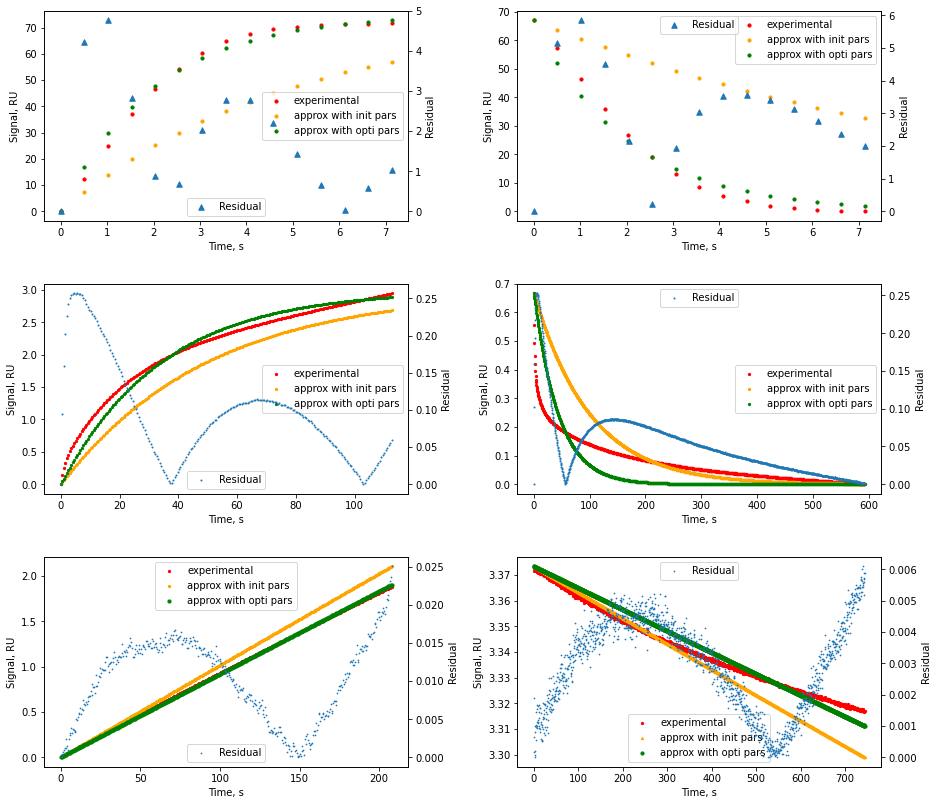

In [89]:
# Fast phases of Association ad Dissociation

xa, ya = xfa, yfa
xd, yd = xfd, yfd

f, axs = plt.subplots(3,2, sharey=False)
ax=axs[0,0]
ax1=axs[0,0].twinx()
ax.scatter(xa, ya, s=10, label='experimental', color = 'red')
ax.scatter(xa, assoc(xa, R_eq_fast, *ini_pars_fast), s=10, label='approx with init pars', color="orange")
ax.scatter(xa, assoc(xa, R_eq_fast, kc1,kd1),s=10, label='approx with opti pars', color='green')
ax.legend(loc='right')
ax.set_xlabel("Time, s")
ax.set_ylabel("Signal, RU")
ax1.scatter(xa, abs(ya-assoc(xa, R_eq_fast, kc1,kd1)), marker='^', s=30, linestyle='solid', label="Residual")
ax1.set_ylabel("Residual")
ax1.legend(loc='lower center')

ax = axs[0,1]
ax1 = axs[0,1].twinx()
ax.scatter(xd, yd, s=10, label='experimental', color = 'red')
ax.scatter(xd, diss(xd, max(yd), ini_pars_fast[-1]),s=10, label='approx with init pars', color="orange")
ax.scatter(xd, diss(xd, max(yd), kd1),s=10, label='approx with opti pars', color='green')
ax.legend(loc='best')
ax.set_xlabel("Time, s")
ax.set_ylabel("Signal, RU")
ax1.scatter(xa, abs(yd-diss(xd, max(yd), kd1)),marker='^', s=30,linestyle='solid', label="Residual")
ax1.set_ylabel("Residual")
ax1.legend(loc='upper center')

yfa_approx = assoc(xa, R_eq_fast, kc1,kd1)
yfd_approx = diss(xd, max(yd), kd1)



# Medium phases of Association ad Dissociation
xa, ya = xma, yma
xd, yd = xmd, ymd

ax = axs[1,0]
ax1 = axs[1,0].twinx()
ax.scatter(xa, ya, s=5, label='experimental', color = 'red')
ax.scatter(xa, assoc(xa, R_eq_medium, *ini_pars_medium), s=5, label='approx with init pars', color="orange")
ax.scatter(xa, assoc(xa, R_eq_medium, kc2,kd2),s=5, label='approx with opti pars', color='green')
ax.legend(loc='right')
ax.set_xlabel("Time, s")
ax.set_ylabel("Signal, RU")
ax1.scatter(xa, abs(ya-assoc(xa, R_eq_medium, kc2,kd2)), s=1, label="Residual")
ax1.set_ylabel("Residual")
ax1.legend(loc='lower center')

ax = axs[1,1]
ax1 = axs[1,1].twinx()
ax.scatter(xd, yd, s=5, label='experimental', color = 'red')
ax.scatter(xd, diss(xd, max(yd), ini_pars_medium[-1]),s=5, label='approx with init pars', color="orange")
ax.scatter(xd, diss(xd, max(yd), kd2),s=5, label='approx with opti pars', color='green')
ax.legend(loc='right')
ax.set_xlabel("Time, s")
ax.set_ylabel("Signal, RU")
ax1.scatter(xd, abs(yd-diss(xd, max(yd), kd2)),s=1, label="Residual")
ax1.set_ylabel("Residual")
ax1.legend(loc='upper center')

yma_approx = assoc(xa, R_eq_medium, kc2,kd2)
ymd_approx = diss(xd, max(yd), kd2)


# Slow phases of Association ad Dissociation
xa, ya = xsa, ysa
xd, yd = xsd, ysd

ax = axs[2,0]
ax1 = axs[2,0].twinx()
ax.scatter(xa, ya, s=5, label='experimental', color = 'red')
ax.scatter(xa, assoc(xa, R_eq_slow, *ini_pars_slow), s=5, label='approx with init pars', color="orange")
ax.scatter(xa, assoc(xa, R_eq_slow, kc3,kd3),s=10, label='approx with opti pars', color='green')
ax.legend(loc='upper center')
ax.set_xlabel("Time, s")
ax.set_ylabel("Signal, RU")
ax1.scatter(xa, abs(ya-assoc(xa, R_eq_slow, kc3,kd3)),s=0.5, label="Residual")
ax1.set_ylabel("Residual")
ax1.legend(loc='lower center')

ax = axs[2,1]
ax1 = axs[2,1].twinx()
ax.scatter(xd, yd, label='experimental', color = 'red', s=5)
ax.scatter(xd, diss(xd, max(yd), ini_pars_slow[-1]),s=5, marker='^', label='approx with init pars', color="orange")
ax.scatter(xd, diss(xd, max(yd), kd3),s=10, label='approx with opti pars', color='green')
ax.legend(loc='lower center')
ax.set_xlabel("Time, s")
ax.set_ylabel("Signal, RU")
ax1.scatter(xd, abs(yd-diss(xd, max(yd), kd3)), label="Residual", s=0.5)
ax1.set_ylabel("Residual")
ax1.legend(loc='upper center')

ysa_approx = assoc(xa, R_eq_slow, kc3,kd3)
ysd_approx = diss(xd, max(yd), kd3)

f.set_figheight(15)
f.set_figwidth(15)
f.subplots_adjust(top = 1, bottom=0.3, hspace=0.3, wspace=0.3) 
plt.show()

ASSEMBLING ALL CURVES AND DEVIATIONS TOGETHER

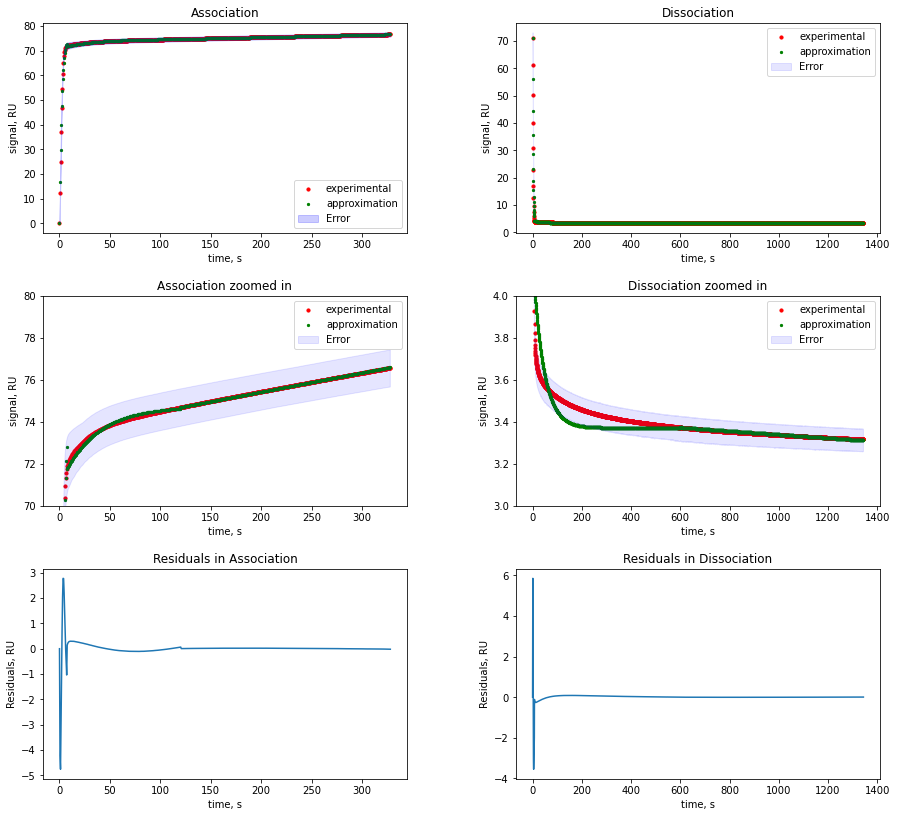

Mean residual in Association = 0.18796023237130155 % 
Mean residual in Association = 0.8681611833789076 %


In [90]:
# Assembling of Association phases
xa = np.concatenate((xfa, xma+xfa[-1], xsa+(xma+xfa[-1])[-1]))
shift1 = cut_it.fast_part(end_of_fast_assoc, ta100, ya100ave)[1][-1]
shift2 = cut_it.slow_part(start_of_slow_assoc, ta100, ya100ave)[1][0]
ya = np.concatenate((yfa_approx, yma_approx+shift1, ysa_approx+shift2 ))

# Assembling of Dissociation phases
xd = np.concatenate((xfd, xmd+xfd[-1], xsd+(xmd+xfd[-1])[-1]))
shift1 = abs(cut_it.fast_part(end_of_fast_diss,td100,yd100ave)[1][0]-yfd_approx[0])
shift2 = abs(cut_it.mid_part(end_of_fast_diss,start_of_slow_diss,td100,yd100ave)[1][0] - ymd_approx[0])
yd = np.concatenate((yfd_approx+shift1, ymd_approx+shift2, ysd_approx ))

# Visualization

f, axs = plt.subplots(3,2)

axs[0,0].scatter(ta100,ya100ave, s = 10, label = 'experimental', color='red')
axs[0,0].scatter(xa,ya, s= 5, c = 'green', label = "approximation")
axs[0,0].fill_between(ta100, ya100min, ya100max,color='blue', label='Error', alpha=0.2)
axs[0,0].legend(loc='best')
axs[0,0].set_xlabel('time, s')
axs[0,0].set_ylabel('signal, RU')
axs[0,0].set_title("Association")


axs[0,1].scatter(td100,yd100ave, s = 10, label = 'experimental', color='red')
axs[0,1].scatter(xd,yd, s= 5, c = 'green', label = "approximation")
axs[0,1].fill_between(td100, yd100min, yd100max,color='blue', label='Error', alpha=0.1)
axs[0,1].legend(loc='best')
axs[0,1].set_xlabel('time, s')
axs[0,1].set_ylabel('signal, RU')
axs[0,1].set_title("Dissociation")

axs[1,0].scatter(ta100,ya100ave, s = 10, label = 'experimental', color='red')
axs[1,0].scatter(xa,ya, s= 5, c = 'green', label = "approximation")
axs[1,0].fill_between(ta100, ya100min, ya100max,color='blue', label='Error', alpha=0.1)
axs[1,0].legend(loc='best')
axs[1,0].set_xlabel('time, s')
axs[1,0].set_ylabel('signal, RU')
axs[1,0].set_title("Association zoomed in")
axs[1,0].set_ylim(70,80)

axs[1,1].scatter(td100,yd100ave, s = 10, label = 'experimental', color='red')
axs[1,1].scatter(xd,yd, s= 5, c = 'green', label = "approximation")
axs[1,1].fill_between(td100, yd100min, yd100max,color='blue', label='Error', alpha=0.1)
axs[1,1].legend(loc='best')
axs[1,1].set_xlabel('time, s')
axs[1,1].set_ylabel('signal, RU')
axs[1,1].set_title("Dissociation zoomed in")
axs[1,1].set_ylim(3,4)

axs[2,0].plot(ta100,(ya100ave-np.delete(ya, [-1])), label="Residuals")
axs[2,0].set_xlabel("time, s")
axs[2,0].set_ylabel("Residuals, RU")
axs[2,0].set_title("Residuals in Association")

axs[2,1].plot(td100,(yd100ave-np.delete(yd, [-1,-2])),label="Residuals")
axs[2,1].set_xlabel("time, s")
axs[2,1].set_ylabel("Residuals, RU")
axs[2,1].set_title("Residuals in Dissociation")

f.set_figheight(15)
f.set_figwidth(15)
f.subplots_adjust(top = 1, bottom=0.3, hspace=0.3, wspace=0.3) 
plt.show()

# Mean Res

mean_loss_a = np.mean(abs(np.delete(ya100ave,0)-np.delete(ya, [0,-1]))/np.delete(ya100ave,0)*100)
mean_loss_d = np.mean(abs(yd100ave-np.delete(yd, [-1,-2]))/yd100ave*100)
print(f"Mean residual in Association = {mean_loss_a} %", f"\nMean residual in Association = {mean_loss_d} %")

